<div style="padding-bottom:30px">
<a href="http://iqtk.io"><img src="https://discover.iqtk.io/assets/logotype_blue_small.png" style="width:100px; margin-left:0px"></img></a>
<p style="color:#9E9E9E">
<a href="http://iqtk.io">Getting Started Guide</a> // <a href="https://goo.gl/forms/2cOmuUrQ3n3CKpim1">Documentation Feedback</a></p>
</div>

<h1 style="color:#9E9E9E">Metabolomics data preprocessing</h1>

In this tutorial we initiate a distributed file conversion of Agilent .d files into .mzML from the DataFlow UI permitting downstream analysis with XCMS3 or alternative tools.

There is some background reading so once you've completed the [getting started documentation]() you'll be ready for this tutorial!

<h2 style="color:#9E9E9E">Required Data and Parameterization</h2>

The starting point for this workflow is the following:

<ul style="font-size:15px">
<ol><b>1. Agilent .d archives:</b> GCS path to a file listing Agilent .d files to convert.</ol>
</ul>

Each of these should be present on Google Cloud Storage. Next we discuss two of the following three ways workflows can be triggered.

<ul style="font-size:15px">
<ol>1. From the DataFlow UI</ol>
<ol>2. Using the `iqtk` command-line tool</ol>
<ol>3. [Programmatically](https://github.com/iqtk/iqtk/tree/master/inquiry/functions/storage-trigger) in response to an instrument data sync event.</ol>
</ul>

<h3 style="color:#9E9E9E">Parameterization from the DataFlow UI</h2>

The easiest way to initiate a workflow is from the DataFlow template job submission UI. For this workflow the submission dialog will look as follows and simply requires you provide the GCS paths to the necessary input files.

<img src="https://discover.iqtk.io/assets/submit-sshot-msconvert.png" style="padding:20px; height:600px"></img>

<h3 style="color:#9E9E9E">Parameterization from the command-line</h2>

Initiating workflow runs from the command line requires that the `iqtk` utility is installed on your system (such as via `pip install iqtk`) and that you have authenticated with GCP to access the APIs and file objects referenced by and required for your run. Provided these, a workflow can be initiated using the following command provided a JSON config file like the one following that.

In [ ]:
%%bash
iqtk run metabolomics --config=path_to_your_config.json

```json
{
  "archives": [
    "gs://inquiry-test/tests/toolkit-ms/file.d"
   ]
}

```

Once our job is submitted we'll be able to check its status using the Cloud DataFow UI (as described in the [getting started documentation]()) which should look like the following:

<img src="https://discover.iqtk.io/assets/wf-sshot-metabolomics.png" style="padding:20px; height:1000px"></img>

For the interested and for reference we include below the code for this workflow and its primary operation:

```python


class ConvertWorkflow(Workflow):
    """Convert Agilent .d files into mzML format using msconvert."""

    def __init__(self):
        """Initialize an msconvert workflow."""
        self.meta = {
          "name": "msconvert",
          "description": "Convert Agilent .d files into mzML.",
          "parameters": [{
            "name": "archives",
            "label": "Archives list file",
            "help_text": "List of GCS paths to .d files.",
            "regexes": ["^gs:\/\/[^\n\r]+$"],
            "is_optional": False
          }]
        }
        super(ConvertWorkflow, self).__init__()

    def define(self):
        return (util.fc_create(self.p, self.args.archives)
                | task.ContainerTaskRunner(MSConvert(self.args)))


class MSConvert(iqf.task.ContainerTask):

    def __init__(self, args):
        """Initialize an MSConvert container task."""
        container = iqf.task.ContainerTaskResources(
            disk=60, cpu_cores=4, ram=8,
            image='gcr.io/jbei-cloud/msconvert:0.0.1')
        super(MSConvert, self).__init__(task_label='msconvert', args=args,
                                        container=container)

    def process(self, file_path):

        # Declare intermediates
        decomp_target = self.out_path + '/decompressed'
        converted_target = localize('converted-%s.mzML' % iqf.util.shaker.shake(),
                                    self.out_path)

        # Construct command
        cmd = iqf.util.Command(['mkdir', '-p', decomp_target])

        if file_path.endswith('.tar.gz') or file_path.endswith('.tgz'):
            cmd.chain(['tar', '-xzf', localize(file_path),
                       '-C', decomp_target, '--strip-components=1'])

        cmd.chain(["wine", "msconvert", decomp_target, "--zlib",
                   "-o", self.out_path])
        cmd.chain(["mv", self.out_path + "/*.mzML", converted_target])

        yield self.submit(cmd.txt, inputs=[file_path],
                          expected_outputs=[{'name': 'converted.mzML',
                                             'file_type': 'mzml'}])


```

<h2 style="color:#9E9E9E">Exploring the data</h2>

When the workflow is complete you can obtain the path in Google Cloud Storage to the resulting converted files as described in the [getting started documentation](). Currently the processing of these files directly into BigQuery database entries is not part of the core pipeline and can instead be run from [this](https://github.com/iqtk/iqtk/blob/master/inquiry/docs/tutorials/analyze-metabolite-mdvs-xcms3.ipynb) R kernel jupyter notebook. What follows is an illustration of how a complete metabolomics dataset can be browsed and obtained from BigQuery for subsequent analysis. First, a screenshot of the BigQuery UI showing a metabolomics dataset:

<img src="https://discover.iqtk.io/assets/bq-sshot-metabolomics.png" style="padding:20px; height:400px"></img>

Next we'll pull down a subset of this data from BigQuery into a Pandas data_frame permitting further exploratory and interactive usage.

In [3]:
import google.datalab.bigquery as bq
query = bq.Query('SELECT * FROM `jbei-cloud.metabolomics.feihnexample3` LIMIT 3')
output_options = bq.QueryOutput.table(use_cache=False)
result = query.execute(output_options=output_options).result()
result.to_dataframe()

,Samples,Factors,_1_2_4_benzenetriol,_1_monostearin,_2_hydroxyvaleric_acid,_3_phosphoglycerate,_5_hydroxynorvaline_NIST,adenosine,adenosine_5_monophosphate,adipic_acid,...,_222169,_222058,_222051,_222047,_222036,_222029,_199553,_199322,_207188,_199232
0,LabF_115909,Arabidopsis Genotype:fatb-ko KD; At1g08510 | P...,3566,450,931,2005,2403,407,1650,8148,...,254,358,788,2015,7857,1496,378,1440,916,324
1,LabF_115904,Arabidopsis Genotype:fatb-ko KD; At1g08510 | P...,1874,987,771,2039,2297,538,2153,2197,...,254,602,949,1952,5013,1840,443,1498,980,321
2,LabF_115914,Arabidopsis Genotype:fatb-ko KD; At1g08510 | P...,1945,1910,1114,1496,2598,575,2204,2149,...,651,751,721,919,5963,1870,425,1423,1006,228


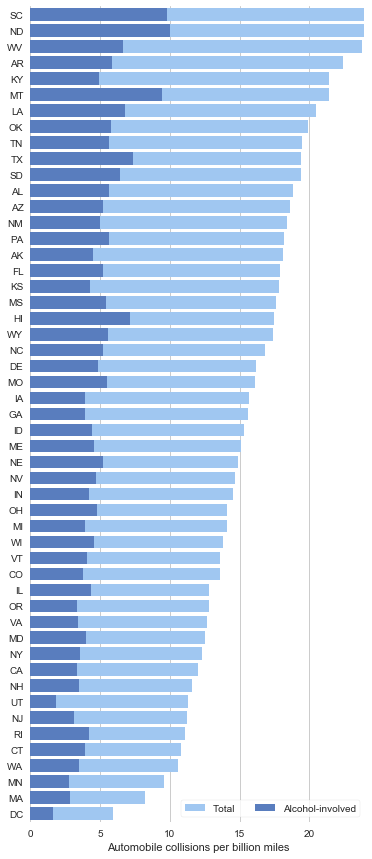

In [2]:
# TODO: At this point, we can do anything that can be done with a pandas dataframe. For example:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

<h3 style="color:#9E9E9E">References</h3>

1. Michael Droettboom, Thomas A Caswell, John Hunter, Eric Firing, Jens Hedegaard Nielsen, Nelle Varoquaux, … Nikita Kniazev. (2017). matplotlib/matplotlib v2.0.1 [Data set]. Zenodo. http://doi.org/10.5281/zenodo.570311
2. Gatto L and Lilley K (2012). “MSnbase - an R/Bioconductor package for isobaric tagged mass spectrometry data visualization, processing and quantitation.” Bioinformatics, 28, pp. 288-289.
3. Smith, C.A., Want, E.J., O'Maille, G., Abagyan,R., Siuzdak and G. (2006). “XCMS: Processing mass spectrometry data for metabolite profiling using nonlinear peak alignment, matching and identification.” Analytical Chemistry, 78, pp. 779–787.
4. Tautenhahn R, Boettcher C and Neumann S (2008). “Highly sensitive feature detection for high resolution LC/MS.” BMC Bioinformatics, 9, pp. 504.
5. Benton HP, Want EJ and Ebbels TMD (2010). “Correction of mass calibration gaps in liquid chromatography-mass spectrometry metabolomics data.” BIOINFORMATICS, 26, pp. 2488.

<h3 style="color:#9E9E9E">Contact</h3>

Want to get in touch? You can [provide feedback](https://goo.gl/forms/2cOmuUrQ3n3CKpim1) regarding this or other documentation,
[reach out to us](https://goo.gl/forms/j8FWdNJqABAoJvcW2) regarding collaboration, or [request a new feature or analytical capability](https://goo.gl/forms/dQm3SDcoNZsV7AAd2). We're looking forward to hearing from you!

<div style="padding-top: 30px">
<p style="color:#9E9E9E; text-align:center">This notebook was prepared as part of the <a href="https://github.com/iqtk/iqtk">Inquiry Toolkit</a> project at the Joint BioEnergy Institute (JBEI). Learn more at https://www.jbei.org/.</p>
<p style="color:#9E9E9E; text-align:center">The Joint BioEnergy Institute is a program of the U.S. Department of Energy Office of Science.</p>
<p style="color:#9E9E9E; text-align:center">© Regents of the University of California, 2017. Licensed under a BSD-3 <a href="https://github.com/iqtk/iqtk/blob/master/LICENSE">license</a>.</p>
<img src="https://discover.iqtk.io/assets/logotype_blue_small.png" style="width:100px"></img>
</div>